## Add SB1 geographic information.

In [1]:
import _utils
import geopandas as gpd
import numpy as np
import pandas as pd
from calitp.sql import to_snakecase

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
import fsspec
from calitp import *
from calitp.storage import get_fs

fs = get_fs()
import os

In [3]:
pd.options.display.max_columns = 200
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### Non SHOPP-ATP-TIRCP

In [4]:
# Read in 10 Year non SHOPP with ATP and TIRCP
nonshopp = to_snakecase(
    pd.read_excel(f"{_utils.GCS_FILE_PATH}cleaned_data_atp_tircp.xlsx")
)

In [5]:
# Subset to join.
non_shopp_subset = [
    "ppno",
    "ct_project_id",
    "ea",
    "project_name",
    "lead_agency",
    "previous_caltrans_nominations",
    "full_county_name",
    "district",
    "project_description",
    "current_phase",
    "primary_mode",
    "urban_rural",
    "total_project_cost__$1,000",
    "total_unfunded_need__$1,000",
    "shs_capacity_increase_detail",
    "current_phase",
]

In [6]:
nonshopp = nonshopp[non_shopp_subset]

In [7]:
# Lower case and clean project names
nonshopp.project_name = (
    nonshopp.project_name.str.lower().str.strip().str.split("20").str[0]
)

In [8]:
nonshopp.district = nonshopp.district.map("{:02}".format)

### Sb1 Geo
* https://odpsvcs.dot.ca.gov/arcgis/rest/services/RCA/RCA_Projects_032022/FeatureServer

#### Step 1: Read in all projects
* Compare with CSV.
* Clean it up.

In [9]:
sb1_all_projects_url = "https://odpsvcs.dot.ca.gov/arcgis/rest/services/RCA/RCA_Projects_032022/FeatureServer/22/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*+&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=&resultOffset=&resultRecordCount=&returnTrueCurves=false&sqlFormat=none&f=geojson"

In [10]:
# Read in SB1 csv
# sb1_csv = to_snakecase(pd.read_csv(f"{_utils.GCS_FILE_PATH}RebuildingCA_map_Data.csv"))

In [11]:
sb1_all_projects = to_snakecase(gpd.read_file(sb1_all_projects_url))

In [12]:
sb1_all_projects.shape, sb1_all_projects.projecttitle.nunique()

((9632, 37), 5453)

In [13]:
# Same rows, different columns.
# sb1_all_projects.shape, sb1_csv.shape

In [14]:
# Project ID matches
# csv_projectid = set(sb1_csv.project_id.unique().tolist())
# geojson_projectid = set(sb1_all_projects.projectid.unique().tolist())
# csv_projectid - geojson_projectid

In [15]:
# set(sb1_all_projects.columns).difference(set(sb1_csv.columns))

In [16]:
# Align funding
sb1_all_projects = _utils.align_funding_numbers(
    sb1_all_projects,
    [
        "totalcost",
        "sb1funds",
    ],
)

In [17]:
# Lower case and clean project names
sb1_all_projects.projecttitle = (
    sb1_all_projects.projecttitle.str.lower().str.strip().str.split("20").str[0]
)

In [18]:
# No geometry, just drop it
sb1_all_projects = sb1_all_projects.drop(columns=["geometry"])

In [19]:
full_gdf2.programcodes.unique()

NameError: name 'full_gdf2' is not defined

In [ ]:
tircp_atp = full_gdf2.loc[full_gdf2.programcodes.str.contains("TIRCP|ATP")].reset_index(
    drop=True
)

In [ ]:
tircp_atp_nonshopp = nonshopp.loc[
    nonshopp.previous_caltrans_nominations.str.contains("TIRCP|ATP")
].reset_index(drop=True)

In [20]:
# Fill in NA
sb1_all_projects = sb1_all_projects.fillna(sb1_all_projects.dtypes.replace({"float64": 0.0, "object": "None"}))

#### Step 2: Read in files with geometry 
* https://odpsvcs.dot.ca.gov/arcgis/rest/services/RCA/RCA_Projects_032022/FeatureServer

In [21]:
url_pt1 = "https://odpsvcs.dot.ca.gov/arcgis/rest/services/RCA/RCA_Projects_032022/FeatureServer/"
url_pt2 = "/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=*+&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=&resultOffset=&resultRecordCount=&returnTrueCurves=false&sqlFormat=none&f=geojson"

In [22]:
def rest_server():
    full_gdf = pd.DataFrame()
    for i in [*range(0,22)]:
        df = to_snakecase(gpd.read_file(f"{url_pt1}{i}{url_pt2}"))
        full_gdf = pd.concat([full_gdf, df], axis=0)
    return full_gdf

In [23]:
sb1_geo = rest_server()

<AxesSubplot:>

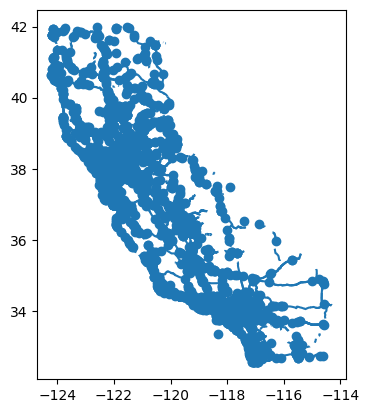

In [27]:
sb1_geo.plot()

In [ ]:
# Fill in NA..turn this into a func
sb1_geo = sb1_geo.fillna(sb1_geo.dtypes.replace({"float64": 0.0, "object": "None"}))

In [ ]:
# Subset to join back to the 9,000 projects above
# subset = ['objectid', 'agencyids', 'projecttitle','programcodes', 'projectid','geometry']

In [ ]:
sb1_project_id = clean_project_id(sb1_project_id, "project_id")

In [ ]:
full_gdf2 = clean_project_id(full_gdf2, "projectid")

In [ ]:
full_gdf2.projectid.nunique(), sb1_project_id.project_id.nunique(), len(sb1_project_id)

In [ ]:
pd.merge(
    sb1_project_id,
    full_gdf2,
    how="outer",
    left_on=["project_id"],
    right_on=["projectid"],
    indicator=True,
)[["_merge"]].value_counts()

In [ ]:
sb1_m = pd.merge(
    full_gdf2,
    sb1_project_id,
    how="left",
    left_on=["projectid"],
    right_on=["project_id"],
)

In [ ]:
sb1_m.project_name = sb1_m.project_name.fillna(sb1_m.projecttitle)

In [ ]:
pd.merge(nonshopp, sb1_m, how="outer", on=["project_name"], indicator=True)[
    ["_merge"]
].value_counts()

In [ ]:
sb1.shape, sb1.project_name.nunique()

In [ ]:
# Titles are not necessarily specifically named.
# Tends to be very general
# sb1.project_name.value_counts()

In [ ]:
sb1_subset = [
    "project_name",
    "implementing_agency",
    "sb1_program",
    "fiscal_year",
    "project_description",
    "total_cost",
    "sb1_funds",
    "is_sb1?",
    "project_status",
    "assembly_districts",
    "senate_districts",
    "congressional_districts",
    "counties",
    "cities",
    "caltrans_districts",
    "on_shs?",
]

In [ ]:
sb1_2 = sb1[sb1_subset]

In [ ]:
sb1.sb1_program.value_counts()

In [ ]:
sb1_2.shape

In [ ]:
# Fill in NA
sb1_2 = sb1_2.fillna(sb1_2.dtypes.replace({"float64": 0.0, "object": "None"}))

In [ ]:
# Align funding
sb1_2 = _utils.align_funding_numbers(
    sb1_2,
    [
        "total_cost",
        "sb1_funds",
    ],
)

In [ ]:
# sb1_geo2 = sb1_geo[subset]

#### Step 3: Figure out why the rows differ between `sb1_all_projects` and `sb1_geo2`

In [ ]:
def clean_project_names_id(df, project_name_col:str, project_id_col: str):
    df[project_name_col] = (df[project_name_col].str.lower().str.strip().str.split("20").str[0])
    
    df[project_id_col] = df[project_id_col].str.replace("'", "").str.lower().str.strip()
    
    # Get rid of | in object cols
    # https://stackoverflow.com/questions/68152902/extracting-only-object-type-columns-in-a-separate-list-from-a-data-frame-in-pand
    for i in df.select_dtypes(include=['object']).columns.to_list():
        df[i] = df[i].str.replace("|", "")
    return df

In [ ]:
sb1_all_projects.shape, sb1_geo.shape

In [ ]:
# Objectid: no cleaning for either of dfs
# This is a int64 dtype...yet zero merges
pd.merge(
    sb1_all_projects,
    sb1_geo,
    how="outer",
    on=["objectid"],
    indicator=True,
)[["_merge"]].value_counts()

In [ ]:
sb1_all_projects = clean_project_names_id(sb1_all_projects, 'projectid', 'projecttitle')

In [ ]:
sb1_geo2 = clean_project_names_id(sb1_geo, 'projectid','projecttitle')

In [ ]:
pd.merge(
    sb1_all_projects,
    sb1_geo2,
    how="outer",
    left_on=["projectid"],
    right_on = ["projectid"],
    indicator=True,
)[["_merge"]].value_counts()

In [ ]:
pd.merge(
    sb1_all_projects,
    sb1_geo2,
    how="outer",
    left_on=["projecttitle", "ct_districts", "agencyid", "fiscalyear"],
    right_on=["projecttitle", "ct_districts", "agencyids", "fiscalyears"],
    indicator=True,
)[["_merge"]].value_counts()

### Merge 9 Sample Non SHOPP with Geojson

In [ ]:
for i in ["project_name", "ea", "ppno"]:
    nonshopp[i] = nonshopp[i].str.lower()

In [ ]:
nine_projects_names = [
    "LA-210 Median Concrete Barrier Renovation",
    "SR-14 Widening Project",
    "US 395 Freight Mobility and Safety Project",
    "East Bay Greenway Multimodal Corridor Project",
    "Watsonville-Santa Cruz Multimodal Corridor Program",
    "SM 101 Woodside Road Interchange and Port Access Project",
    "I-710 Integrated Corridor Management",
    "Five Cities Multimodal Transportation Network Enhancement Project",
    "SR-86/Avenue 50 New Interchange (Phase II)",
]

In [ ]:
nine_projects_names = [x.lower() for x in nine_projects_names]

In [ ]:
nine_projects_id = [
    "0422000202",
    "0414000032",
    "0520000083",
    "0515000063",
    "0721000056",
    "0716000370",
    "0813000222",
    "0814000144",
    "0414000032",
    "0720000165",
]

In [ ]:
nine_sample_projects = (nonshopp[nonshopp.ct_project_id.isin(nine_projects_id)].reset_index(drop=True))

In [ ]:
# Subset sb1_geo to only districts these 9 projects are located in
sb1_geo3 = sb1_geo2[sb1_geo2["ct_districts"].str.contains(('05|07|04|08'))].reset_index(drop = True)

In [ ]:
sb1_geo3.explore()

### Merge all other Projects

In [ ]:
# 62 matches
pd.merge(
    nonshopp,
    sb1_all_projects,
    how="outer",
    left_on=["project_name"],
    right_on=["projecttitle"],
    indicator=True,
)[["_merge"]].value_counts()

### Tircp
* None of the projects from TIRCP are mapping, even though the names appear the same.

In [ ]:
# sb1_tircp = sb1_2.loc[sb1_2.sb1_program == "Transit and Intercity Rail Capital Program"].reset_index(drop = True)

In [ ]:
# sb1_tircp[['project_name','caltrans_districts','counties']].sort_values('project_name').head(2)

In [ ]:
# tircp_sb[['project_name']].sort_values(by = 'project_name')

In [ ]:
# tircp_shopp[['project_name']].sort_values(by = 'project_name')

In [ ]:
tircp_shopp = df.loc[
    df.previous_caltrans_nominations.str.contains("TIRCP")
].reset_index(drop=True)

In [ ]:
# why are there no matches??
pd.merge(tircp_shopp, tircp_sb, how="outer", on=["project_name"], indicator=True)[
    ["_merge"]
].value_counts()